In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score

In [5]:
import sys
import warnings

if "google.colab" in sys.modules:
    ## Colab에서 실행하는 경우 필요한 라이브러리를 미리 설치합니다.
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip3 install eli5
    !pip install pdpbox
#     !pip install plotly==4.*

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 5.3 MB/s 
     |████████████████████████████████| 959 kB 52.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.1-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 2.13.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.1 which is incompatible.


문제 정의

셀링클럽의 입장에서 어떤 선수를 키우는것, 어떻게 키우는가를 어떻게 정할까

1. 선수가치와 시즌스텟 상관성
2. 시즌스텟 변화에 따른 가치변동 -> 어떤 스텟을 집중하면 가치를 키울 수 있을까?
3. Road to win

### 전처리 과정

### 데이터 선정, 결측치, 이상치 처리

In [6]:
df_1718 = pd.read_csv('transfermarkt_fbref_201718.csv', delimiter=';', index_col=0)
df_1819 = pd.read_csv('transfermarkt_fbref_201819.csv', delimiter=';', index_col=0)
df_1920 = pd.read_csv('transfermarkt_fbref_201920.csv', delimiter=';', index_col=0)

In [7]:
df_1819.head()

,player,nationality,position,squad,age,birth_year,value,height,position2,foot,...,Pts/G,xG,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season
Column1,,,,,,,,,,,,,,,,,,,,,
207.0,Borja Bastón,es ESP,FW,Alavés,25.0,1992.0,2000000.0,186.0,Forward - Centre-Forward,right,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#
363.0,Burgui,es ESP,"MF,FW",Alavés,24.0,1993.0,1500000.0,184.0,Forward - Left Winger,right,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#
399.0,Jonathan Calleri,ar ARG,FW,Alavés,24.0,1993.0,9000000.0,181.0,Forward - Centre-Forward,right,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#
704.0,Rubén Duarte,es ESP,DF,Alavés,22.0,1995.0,5000000.0,172.0,Defender - Left-Back,left,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#
738.0,Rodrigo Ely,br BRA,DF,Alavés,24.0,1993.0,2000000.0,188.0,Defender - Centre-Back,right,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#


In [8]:
df_1819.shape

(2232, 399)

In [9]:
df_1920.head()

,player,nationality,position,squad,age,birth_year,value,height,position2,foot,...,Pts/G,xG,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season
Column1,,,,,,,,,,,,,,,,,,,,,
21,Martin Aguirregabiria,es ESP,DF,AlavĂ©s,23,1996,4000000,178,Defender - Right-Back,right,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
390,Oliver Burke,sco SCO,"MF,FW",AlavĂ©s,22,1997,4000000,188,Forward - Right Winger,right,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
430,VĂ­ctor Camarasa,es ESP,MF,AlavĂ©s,25,1994,4000000,183,Midfielder - Central Midfield,right,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
737,RubĂ©n Duarte,es ESP,DF,AlavĂ©s,23,1995,4000000,172,Defender - Left-Back,left,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
770,Rodrigo Ely,br BRA,DF,AlavĂ©s,25,1993,1000000,188,Defender - Centre-Back,right,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#


In [10]:
print(df_1718.shape)
print(df_1819.shape)
print(df_1920.shape)

(2232, 399)
(2232, 399)
(2644, 399)


In [11]:
player_corrected = [i for i in df_1920['player']]
squad_corrected = [i for i in df_1920['squad']]

In [12]:
for corrupted_column in [player_corrected, squad_corrected]:
    for indice_j, nom_j in enumerate(corrupted_column) :
        tab_c = list(nom_j)
        l = len(tab_c)
        for indice_c,caractere in enumerate(tab_c) :
            if caractere == 'Ă' :
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '\x81' :
                        tab_c[indice_c] = 'A'
                        del tab_c[indice_c + 1]
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '\xad' :
                        tab_c[indice_c] = 'i'
                        del tab_c[indice_c + 1]
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '\x98' :
                        tab_c[indice_c] = 'O'
                        del tab_c[indice_c + 1]
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '©' :
                        tab_c[indice_c] = 'e'
                        del tab_c[indice_c + 1]
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == 'ˇ' :
                        tab_c[indice_c + 1] = 'a'
                        del tab_c[indice_c + 1]  
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '‰' :
                        tab_c[indice_c] = 'E'
                        del tab_c[indice_c + 1]   
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == 'ł' :
                        tab_c[indice_c] = 'o'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '«' :
                        tab_c[indice_c] = 'e'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == 'Ż' :
                        tab_c[indice_c] = 'i'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '‡' :
                        tab_c[indice_c] = 'c'
                        del tab_c[indice_c + 1]  
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '–' :
                        tab_c[indice_c] = 'O'
                        del tab_c[indice_c + 1]    
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '“' :
                        tab_c[indice_c] = 'O'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '±' :
                        tab_c[indice_c] = 'n'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '' :
                        tab_c[indice_c] = 'A'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == 'Ľ' :
                        tab_c[indice_c] = 'u'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '¶' :
                        tab_c[indice_c] = 'o'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '¸' :
                        tab_c[indice_c] = 'o'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == 'Ş' :
                        tab_c[indice_c] = 'e'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '§' :
                        tab_c[indice_c] = 'c'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == 'ş' :
                        tab_c[indice_c] = 'u'
                        del tab_c[indice_c + 1]
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '¤' :
                        tab_c[indice_c] = 'a'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '°' :
                        tab_c[indice_c] = 'o'
                        del tab_c[indice_c + 1] 
                        break
                    else :
                        tab_c[indice_c] = 'a'
                        break
            if caractere == 'Ł':
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == 'o' :
                        tab_c[indice_c] = 'o'
                        del tab_c[indice_c + 1] 
                        break
            if caractere == 'Ĺ' :
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == 'ź' :
                        tab_c[indice_c] = 's'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '\x81' :
                        tab_c[indice_c] = 'L'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '\xa0' :
                        tab_c[indice_c] = 'S'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == 'ˇ' :
                        tab_c[indice_c] = 's'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == 'ľ' :
                        tab_c[indice_c] = 'z'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '»' :
                        tab_c[indice_c] = 'Z'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '„' :
                        tab_c[indice_c] = 'n'
                        del tab_c[indice_c + 1] 
                        break
            if caractere == 'Ä' :
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '›' :
                        tab_c[indice_c] = 'e'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == 'Ť' :
                        tab_c[indice_c] = 'c'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '…' :
                        tab_c[indice_c] = 'a'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '™' :
                        tab_c[indice_c] = 'e'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '‡' :
                        tab_c[indice_c] = 'c'
                        del tab_c[indice_c + 1] 
                        break
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '\x83' :
                        tab_c[indice_c] = 'a'
                        del tab_c[indice_c + 1] 
                        break
            if caractere == 'Č' :
                    if (indice_c + 1) < l and tab_c[indice_c + 1] == '›' :
                        tab_c[indice_c] = 't'
                        del tab_c[indice_c + 1] 
                        break
        corrupted_column[indice_j] = "".join(tab_c)

In [13]:
df_1920 = df_1920.drop(['player'], axis=1)
df_1920.insert(1, 'player', player_corrected)
df_1920 = df_1920.drop(['squad'], axis=1)
df_1920.insert(4, 'squad', squad_corrected)
df_1920

,nationality,player,position,age,squad,birth_year,value,height,position2,foot,...,Pts/G,xG,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season
Column1,,,,,,,,,,,,,,,,,,,,,
21,es ESP,Martin Aguirregabiria,DF,23,Alaves,1996,4000000,178,Defender - Right-Back,right,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
390,sco SCO,Oliver Burke,"MF,FW",22,Alaves,1997,4000000,188,Forward - Right Winger,right,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
430,es ESP,Victor Camarasa,MF,25,Alaves,1994,4000000,183,Midfielder - Central Midfield,right,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
737,es ESP,Ruben Duarte,DF,23,Alaves,1995,4000000,172,Defender - Left-Back,left,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
770,br BRA,Rodrigo Ely,DF,25,Alaves,1993,1000000,188,Defender - Centre-Back,right,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,pt POR,Daniel Podence,"FW,MF",23,Wolves,1995,12000000,165,Forward - Right Winger,right,...,1.55,47.1,34.8,12.3,0.32,24758,0,0,NaN,201920#
2202,ma MAR,Romain Saiss,DF,29,Wolves,1990,4000000,188,Defender - Centre-Back,left,...,1.55,47.1,34.8,12.3,0.32,24758,0,0,NaN,201920#
2523,es ESP,Adama Traore,"FW,MF",23,Wolves,1996,25000000,178,Forward - Right Winger,right,...,1.55,47.1,34.8,12.3,0.32,24758,0,0,NaN,201920#


In [14]:
df = pd.concat([df_1718, df_1819, df_1920])
df.head()

,player,nationality,position,squad,age,birth_year,value,height,position2,foot,...,Pts/G,xG,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season
379.0,Burgui,es ESP,"FW,MF",Alavés,23.0,1993.0,1800000.0,186.0,attack - Left Winger,right,...,1.24,39.0,53.2,-14.2,-0.37,"16,819",0.0,0.0,0.0,201718#
2530.0,Raphaël Varane,fr FRA,DF,Real Madrid,24.0,1993.0,70000000.0,191.0,Defender - Centre-Back,right,...,2.00,83.3,45.4,37.9,1.00,66161,1.0,1.0,0.0,201718#
721.0,Rubén Duarte,es ESP,DF,Alavés,21.0,1995.0,2000000.0,179.0,Defender - Left-Back,left,...,1.24,39.0,53.2,-14.2,-0.37,"16,819",0.0,0.0,0.0,201718#
2512.0,Samuel Umtiti,fr FRA,DF,Barcelona,23.0,1993.0,60000000.0,182.0,Defender - Centre-Back,left,...,2.45,78.3,41.1,37.2,0.98,66603,1.0,0.0,0.0,201718#
882.0,Manu García,es ESP,MF,Alavés,31.0,1986.0,1800000.0,183.0,midfield - Defensive Midfield,left,...,1.24,39.0,53.2,-14.2,-0.37,"16,819",0.0,0.0,0.0,201718#


In [15]:
print(df.columns.values)

['player' 'nationality' 'position' 'squad' 'age' 'birth_year' 'value'
 'height' 'position2' 'foot' 'league' 'games' 'games_starts' 'minutes'
 'goals' 'assists' 'pens_made' 'pens_att' 'cards_yellow' 'cards_red'
 'goals_per90' 'assists_per90' 'goals_assists_per90' 'goals_pens_per90'
 'goals_assists_pens_per90' 'xg' 'npxg' 'xa' 'xg_per90' 'xa_per90'
 'xg_xa_per90' 'npxg_per90' 'npxg_xa_per90' 'minutes_90s' 'shots_total'
 'shots_on_target' 'shots_free_kicks' 'shots_on_target_pct'
 'shots_total_per90' 'shots_on_target_per90' 'goals_per_shot'
 'goals_per_shot_on_target' 'npxg_per_shot' 'xg_net' 'npxg_net'
 'passes_completed' 'passes' 'passes_pct' 'passes_total_distance'
 'passes_progressive_distance' 'passes_completed_short' 'passes_short'
 'passes_pct_short' 'passes_completed_medium' 'passes_medium'
 'passes_pct_medium' 'passes_completed_long' 'passes_long'
 'passes_pct_long' 'xa_net' 'assisted_shots' 'passes_into_final_third'
 'passes_into_penalty_area' 'crosses_into_penalty_area'
 'progre

In [16]:
df.dtypes[df.dtypes =='object'].index

Index(['player', 'nationality', 'position', 'squad', 'position2', 'foot',
       'league', 'Attendance', 'Season'],
      dtype='object')

In [17]:
df.league.unique()

array(['La Liga', 'Bundesliga', 'Serie A', 'Premier League', 'Ligue 1',
       nan], dtype=object)

In [18]:
df2 = df.copy()
df2 = df2[df2['position']!='0']
df2.dropna(subset=['position'], inplace=True)
df2['main_position'] = df2['position'].str[:2]
df2['main_position'].value_counts()

DF    2461
MF    2243
FW    1742
GK     529
Name: main_position, dtype: int64

In [19]:
df2 = df2.reset_index(drop=True)

In [20]:
df2.describe()

,age,birth_year,value,height,games,games_starts,minutes,goals,assists,pens_made,...,GDiff,Pts,Pts/G,xG,xGA,xGDiff,xGDiff/90,CL,WinCL,CLBestScorer
count,6975.000000,6975.000000,6.975000e+03,6974.000000,6975.000000,6975.000000,6975.000000,6975.000000,6975.000000,6975.000000,...,6975.000000,6975.000000,6975.000000,6975.000000,6975.000000,6975.000000,6975.000000,6975.000000,6975.000000,6563.000000
mean,25.426810,1991.421792,1.023991e+07,181.959994,19.087455,15.022079,1347.838853,1.847742,1.272688,0.170466,...,-0.159427,50.165305,1.372066,48.290294,48.388602,-0.097577,-0.001742,0.183656,0.009319,0.000457
std,4.434405,41.554407,1.654483e+07,9.470734,11.182281,11.206502,973.311063,3.464191,2.034734,0.746305,...,26.274212,17.331806,0.460655,12.708417,10.364497,19.154128,0.523396,0.387231,0.096091,0.021377
min,0.000000,0.000000,5.000000e+01,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,-54.000000,13.000000,0.420000,26.800000,22.700000,-41.500000,-1.090000,0.000000,0.000000,0.000000
25%,22.000000,1989.000000,1.500000e+06,178.000000,9.000000,5.000000,457.000000,0.000000,0.000000,0.000000,...,-18.000000,38.000000,1.060000,39.600000,41.400000,-13.300000,-0.360000,0.000000,0.000000,0.000000
50%,25.000000,1992.000000,4.000000e+06,183.000000,20.000000,14.000000,1247.000000,0.000000,0.000000,0.000000,...,-4.000000,48.000000,1.290000,45.900000,48.400000,-3.200000,-0.090000,0.000000,0.000000,0.000000
75%,28.000000,1996.000000,1.200000e+07,187.000000,29.000000,24.000000,2133.000000,2.000000,2.000000,0.000000,...,14.000000,59.000000,1.620000,54.700000,55.300000,10.200000,0.290000,0.000000,0.000000,0.000000
max,41.000000,2004.000000,2.000000e+08,203.000000,38.000000,38.000000,3420.000000,36.000000,21.000000,14.000000,...,79.000000,100.000000,2.630000,93.000000,84.100000,58.300000,1.780000,1.000000,1.000000,1.000000


In [21]:
df2 = df2.astype({'value' : 'int64'})

In [22]:
df2 = df2.drop(df2[df2.age< 15].index)
df2 = df2.drop(df2[df2.value< 100000].index)
df2 = df2.drop(df2[df2.height< 130].index)

In [23]:
df2.replace({'201920#': 201920, '201819#': 201819, '201718#':201718}, inplace = True)

In [24]:
df2.shape

(6198, 400)

In [25]:
df2.Season.dtype

dtype('int64')

In [26]:
df2 = df2.sort_values(['player', 'Season'])

In [27]:
df2.head(6)

,player,nationality,position,squad,age,birth_year,value,height,position2,foot,...,xG,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season,main_position
4797,Aaron Connolly,ie IRL,FW,Brighton,19.0,2000.0,4000000,175.0,Forward - Centre-Forward,right,...,41.2,54.5,-13.3,-0.35,22369,0.0,0.0,0.0,201920,FW
2190,Aaron Cresswell,eng ENG,DF,West Ham,27.0,1989.0,12000000,170.0,Defender - Left-Back,left,...,37.3,57.8,-20.5,-0.54,56885,0.0,0.0,0.0,201718,DF
4278,Aaron Cresswell,eng ENG,DF,West Ham,28.0,1989.0,10000000,170.0,Defender - Left-Back,left,...,49.1,61.0,-11.9,-0.31,58336,0.0,0.0,0.0,201819,DF
6907,Aaron Cresswell,eng ENG,DF,West Ham,29.0,1989.0,6000000,170.0,Defender - Left-Back,left,...,46.2,61.1,-14.8,-0.39,44155,0.0,0.0,NaN,201920,DF
812,Aaron Hunt,de GER,"MF,FW",Hamburger SV,30.0,1986.0,1500000,183.0,midfield - Attacking Midfield,left,...,37.1,52.7,-15.7,-0.46,50656,0.0,0.0,0.0,201718,MF
397,Aaron Lennon,eng ENG,"MF,FW",Burnley,30.0,1987.0,5000000,165.0,attack - Right Winger,right,...,34.4,48.2,-13.7,-0.36,20688,0.0,0.0,0.0,201718,MF


In [28]:
df2 = df2.reset_index(drop=True)

In [29]:
df2[df2['player'] == 'Adama Soumaoro']

,player,nationality,position,squad,age,birth_year,value,height,position2,foot,...,xG,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season,main_position
70,Adama Soumaoro,fr FRA,DF,Lille,25.0,1992.0,3000000,186.0,Defender - Centre-Back,right,...,37.7,56.8,-19.1,-0.50,31453,0.0,0.0,0.0,201718,DF
71,Adama Soumaoro,fr FRA,DF,Lille,26.0,1992.0,10000000,186.0,Defender - Centre-Back,right,...,58.4,42.7,15.6,0.41,34079,1.0,0.0,0.0,201819,DF
72,Adama Soumaoro,fr FRA,DF,Genoa,27.0,1992.0,8000000,186.0,Defender - Centre-Back,right,...,47.4,59.3,-11.9,-0.31,14016,0.0,0.0,0.0,201920,DF
73,Adama Soumaoro,fr FRA,DF,Lille,27.0,1992.0,8000000,186.0,Defender - Centre-Back,right,...,39.7,29.6,10.1,0.36,36404,0.0,0.0,0.0,201920,DF


com_feat = 공통

gk_feat = 키퍼 적용 feature

- aerials_won_pct = 공중볼 경합 승리 %

- ball_recoveries = 볼리커버리 횟수

- crosses_stopped_gk = 크로스 막은 횟수

- clean_sheets = 클린시트

- def_actions_outside_pen_area_gk = 페널티구역 밖에서 수비행위

- dribble_tackles_pct = 태클 성공 횟수

- MP = 팀 매치 플레이수 

- passes_completed = 패스 성공수

- passes_completed_short = 5~15 yard 패스 수

- passes_completed_medium = 중간거리 패스 수

- passes_completed_long = 롱패스 수

- passes_throws_gk = 던진 횟수

- passes_gk = gk 패스 수




In [30]:
target = 'value'
com_feat = ['age','height', 'W', 'D', 'L','games']
gk_feat = ['ball_recoveries', 'crosses_stopped_gk','clean_sheets', 'def_actions_outside_pen_area_gk', 
           'dribble_tackles_pct', 'avg_distance_def_actions_gk','passes_completed', 'passes_completed_short', 'passes_completed_medium',
           'passes_completed_long', 'passes_throws_gk','passes_gk','goal_kick_length_avg']
play_feat = ['player','main_position','value','aerials_won_pct', 'assists_per90','passes_blocked','carry_distance','ball_recoveries','crosses', 
             'crosses_into_penalty_area', 'dribbles', 'dribbles_completed_pct', 'gca_per90', 'GDiff', 'goals_assists_per90', 'minutes_90s', 'npxg_xa_per90',
            'passes_intercepted', 'passes_pct', 'passes_received_pct', 'sca_per90', 'shots_on_target_pct', 'shots_total_per90',
             'goals_per90', 'goals_per_shot','games','tackles', 'pressures','W', 'D', 'L', 'Pts/G','league','foot']
          #  ,'foot','league', dribbles_completed_pct, dribbles_completed, passes_gk

In [31]:
df3 = df2.copy()
df3 =df3[play_feat]

In [32]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6198 entries, 0 to 6197
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player                     6198 non-null   object 
 1   main_position              6198 non-null   object 
 2   value                      6198 non-null   int64  
 3   aerials_won_pct            6198 non-null   float64
 4   assists_per90              6198 non-null   float64
 5   passes_blocked             6198 non-null   float64
 6   carry_distance             6198 non-null   float64
 7   ball_recoveries            6198 non-null   float64
 8   crosses                    6198 non-null   float64
 9   crosses_into_penalty_area  6198 non-null   float64
 10  dribbles                   6198 non-null   float64
 11  dribbles_completed_pct     6198 non-null   float64
 12  gca_per90                  6198 non-null   float64
 13  GDiff                      6198 non-null   float

In [33]:
df3['diff_val'] = ''
df3['d_aerials_won_pct'] = ''
df3['d_assists_per90'] = ''
df3['d_carry_distance'] = ''
df3['d_passes_blocked'] = ''
df3['d_ball_recoveries'] = ''
df3['d_crosses'] = ''
df3['d_crosses_into_penalty_area'] = ''
df3['d_dribbles'] = ''
df3['d_dribbles_completed_pct'] = ''
df3['d_gca_per90'] = ''
df3['d_goals_assists_per90'] = ''
df3['d_GDiff'] = ''
df3['d_minutes_90s'] = ''
df3['d_npxg_xa_per90'] = ''
df3['d_passes_intercepted'] = ''
df3['d_passes_pct'] = ''
df3['d_passes_received_pct'] = ''
df3['d_sca_per90'] = ''
df3['d_shots_on_target_pct'] = ''
df3['d_shots_total_per90'] = ''
df3['d_goals_per90'] = ''
df3['d_goals_per_shot'] = ''
df3['d_games'] = ''
df3['d_tackles'] = ''
df3['d_pressures'] = ''
df3['d_W'] = ''
df3['d_D'] = ''
df3['d_L'] = ''
df3['d_Pts/G'] = ''


for x in range(len(df3)-1):
  if df3['player'][x] == df3['player'][x+1]:
    # df3['diff_val'][x+1] = ((df3['value'][x+1]-df3['value'][x])/df3['value'][x]).round(3)
    df3['diff_val'][x+1] = df3['value'][x+1]-df3['value'][x]
    df3['d_aerials_won_pct'][x+1] = df3['aerials_won_pct'][x+1]-df3['aerials_won_pct'][x]
    df3['d_assists_per90'][x+1] = df3['assists_per90'][x+1]-df3['assists_per90'][x]
    df3['d_carry_distance'][x+1] = df3['carry_distance'][x+1]-df3['carry_distance'][x]
    df3['d_passes_blocked'][x+1] = df3['passes_blocked'][x+1]-df3['passes_blocked'][x]
    df3['d_ball_recoveries'][x+1] = df3['ball_recoveries'][x+1]-df3['ball_recoveries'][x]
    df3['d_crosses'][x+1] = df3['crosses'][x+1]-df3['crosses'][x]
    df3['d_crosses_into_penalty_area'][x+1] = df3['crosses_into_penalty_area'][x+1]-df3['crosses_into_penalty_area'][x]
    df3['d_dribbles'][x+1] = df3['dribbles'][x+1]-df3['dribbles'][x]
    df3['d_dribbles_completed_pct'][x+1] = df3['dribbles_completed_pct'][x+1]-df3['dribbles_completed_pct'][x]
    df3['d_gca_per90'][x+1] = df3['gca_per90'][x+1]-df3['gca_per90'][x]
    df3['d_goals_assists_per90'][x+1] = df3['goals_assists_per90'][x+1]-df3['goals_assists_per90'][x]
    df3['d_GDiff'][x+1] = df3['GDiff'][x+1]-df3['GDiff'][x]
    df3['d_minutes_90s'][x+1] = df3['minutes_90s'][x+1]-df3['minutes_90s'][x]
    df3['d_npxg_xa_per90'][x+1] = df3['npxg_xa_per90'][x+1]-df3['npxg_xa_per90'][x]
    df3['d_passes_intercepted'][x+1] = df3['passes_intercepted'][x+1]-df3['passes_intercepted'][x]
    df3['d_passes_pct'][x+1] = df3['passes_pct'][x+1]-df3['passes_pct'][x]
    df3['d_passes_received_pct'][x+1] = df3['passes_received_pct'][x+1]-df3['passes_received_pct'][x]
    df3['d_sca_per90'][x+1] = df3['sca_per90'][x+1]-df3['sca_per90'][x]
    df3['d_shots_on_target_pct'][x+1] = df3['shots_on_target_pct'][x+1]-df3['shots_on_target_pct'][x]
    df3['d_shots_total_per90'][x+1] = df3['shots_total_per90'][x+1]-df3['shots_total_per90'][x]
    df3['d_goals_per90'][x+1] = df3['goals_per90'][x+1]-df3['goals_per90'][x]
    df3['d_goals_per_shot'][x+1] = df3['goals_per_shot'][x+1]-df3['goals_per_shot'][x]
    df3['d_games'][x+1] = df3['games'][x+1]-df3['games'][x]
    df3['d_tackles'][x+1] = df3['tackles'][x+1]-df3['tackles'][x]
    df3['d_pressures'][x+1] = df3['pressures'][x+1]-df3['pressures'][x]
    df3['d_W'][x+1] = df3['W'][x+1]-df3['W'][x]
    df3['d_D'][x+1] = df3['D'][x+1]-df3['D'][x]
    df3['d_L'][x+1] = df3['L'][x+1]-df3['L'][x]
    df3['d_Pts/G'][x+1] = df3['Pts/G'][x+1]-df3['Pts/G'][x]
  else:
    df3['diff_val'][x+1] = ''
    df3['d_aerials_won_pct'][x+1] = ''
    df3['d_assists_per90'][x+1] = ''
    df3['d_carry_distance'][x+1] = ''
    df3['d_passes_blocked'][x+1] = ''
    df3['d_ball_recoveries'][x+1] = ''
    df3['d_crosses'][x+1] = ''
    df3['d_crosses_into_penalty_area'][x+1] = ''
    df3['d_dribbles'][x+1] = ''
    df3['d_dribbles_completed_pct'][x+1] = ''
    df3['d_gca_per90'][x+1] = ''
    df3['d_goals_assists_per90'][x+1] = ''
    df3['d_GDiff'][x+1] = ''
    df3['d_minutes_90s'][x+1] = ''
    df3['d_npxg_xa_per90'][x+1] = ''
    df3['d_passes_intercepted'][x+1] = ''
    df3['d_passes_pct'][x+1] = ''
    df3['d_passes_received_pct'][x+1] = ''
    df3['d_sca_per90'][x+1] = ''
    df3['d_shots_on_target_pct'][x+1] = ''
    df3['d_shots_total_per90'][x+1] = ''
    df3['d_goals_per90'][x+1] = ''
    df3['d_goals_per_shot'][x+1] = ''
    df3['d_games'][x+1] = ''
    df3['d_tackles'][x+1] = ''
    df3['d_pressures'][x+1] = ''
    df3['d_W'][x+1] = ''
    df3['d_D'][x+1] = ''
    df3['d_L'][x+1] = ''
    df3['d_Pts/G'][x+1] = ''

### 가치와 스텟 상관성

In [34]:
df2[gk_feat]

,ball_recoveries,crosses_stopped_gk,clean_sheets,def_actions_outside_pen_area_gk,dribble_tackles_pct,avg_distance_def_actions_gk,passes_completed,passes_completed_short,passes_completed_medium,passes_completed_long,passes_throws_gk,passes_gk,goal_kick_length_avg
0,54.0,0.0,0.0,0.0,25.0,0.0,126.0,76.0,31.0,7.0,0.0,0.0,0.0
1,318.0,0.0,0.0,0.0,51.7,0.0,1191.0,502.0,489.0,185.0,0.0,0.0,0.0
2,167.0,0.0,0.0,0.0,36.0,0.0,835.0,437.0,319.0,61.0,0.0,0.0,0.0
3,295.0,0.0,0.0,0.0,40.7,0.0,1241.0,619.0,473.0,131.0,0.0,0.0,0.0
4,213.0,0.0,0.0,0.0,13.5,0.0,883.0,406.0,292.0,165.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6193,211.0,0.0,0.0,0.0,39.1,0.0,1032.0,482.0,449.0,90.0,0.0,0.0,0.0
6194,288.0,0.0,0.0,0.0,61.9,0.0,1643.0,425.0,924.0,281.0,0.0,0.0,0.0
6195,21.0,0.0,0.0,0.0,0.0,0.0,178.0,63.0,99.0,16.0,0.0,0.0,0.0
6196,237.0,0.0,0.0,0.0,54.9,0.0,1197.0,495.0,500.0,175.0,0.0,0.0,0.0


In [35]:

df2_FW = df2[df2.main_position == 'FW']
df2_MF = df2[df2.main_position == 'MF']
df2_DF = df2[df2.main_position == 'DF']
df2_GK = df2[df2.main_position == 'GK']
# 각 포지션별 가치와 가장 높은 상관성을 가지는 10가지 특성

In [36]:
num_features = df2_FW.dtypes[df2_FW.dtypes!='object'].index
FW_corr_feat = df2_FW[num_features].corr()['value'].sort_values(ascending=False).head(10).index
df2_FW[num_features].corr()['value'].sort_values(ascending=False).head(10)

value                       1.000000
gca                         0.640413
gca_passes_live             0.619632
shots_on_target             0.617011
goals                       0.609314
touches_att_pen_area        0.603803
npxg                        0.595781
touches_att_3rd             0.590704
xa                          0.588600
passes_into_penalty_area    0.579842
Name: value, dtype: float64

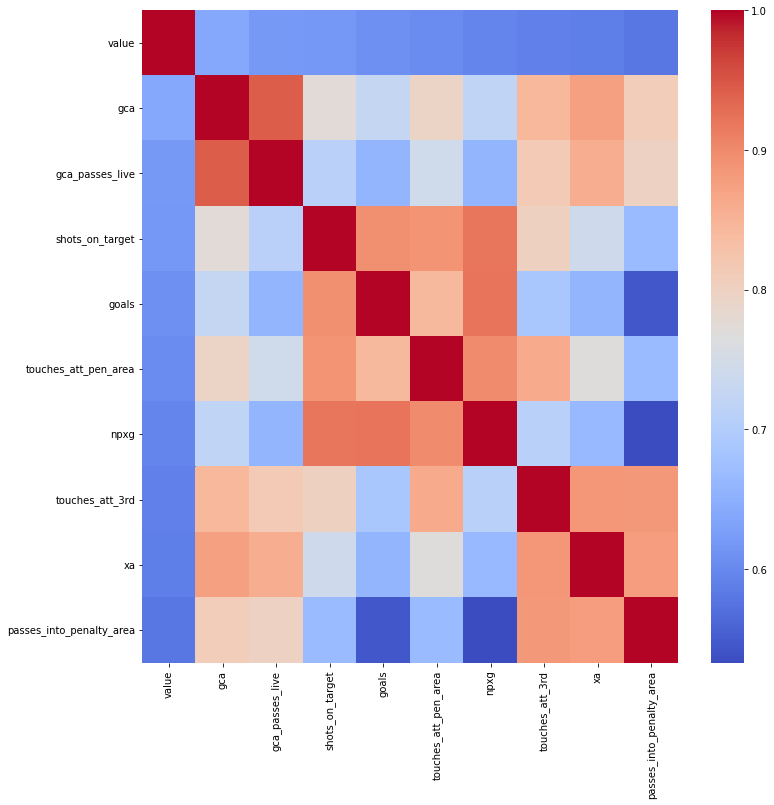

In [37]:
df2_FW_corr = df2_FW[FW_corr_feat].corr()
plt.figure(figsize=(12,12))
sns.heatmap(abs(df2_FW_corr), cmap="coolwarm")

In [38]:
num_features = df2_MF.dtypes[df2_MF.dtypes!='object'].index
df2_MF[num_features].corr()['value'].sort_values(ascending=False).head(10)

value                       1.000000
gca_passes_live             0.538855
passes_completed_short      0.528049
W                           0.524138
passes_short                0.521530
pass_targets                0.520304
passes_received             0.519414
passes_into_penalty_area    0.517148
gca                         0.515898
Pts                         0.513760
Name: value, dtype: float64

In [39]:
num_features = df2_DF.dtypes[df2_DF.dtypes!='object'].index
df2_DF[num_features].corr()['value'].sort_values(ascending=False).head(10)

value                      1.000000
passes_ground              0.564232
passes_received            0.545679
pass_targets               0.538157
passes_completed           0.536322
carries                    0.533749
passes_completed_medium    0.524829
passes_live                0.524708
passes_total_distance      0.520252
W                          0.517329
Name: value, dtype: float64

In [40]:
num_features = df2_GK.dtypes[df2_GK.dtypes!='object'].index
df2_GK[num_features].corr()['value'].sort_values(ascending=False).head(10)

value                      1.000000
wins_gk                    0.641606
clean_sheets               0.613038
passes_ground              0.454613
passes_medium              0.447941
passes_completed_medium    0.447861
Pts                        0.433305
games_starts               0.430323
games                      0.429746
minutes                    0.429276
Name: value, dtype: float64

In [41]:
# len(gk_feat)

In [42]:
# df2_GK[df2_GK.MP<30]

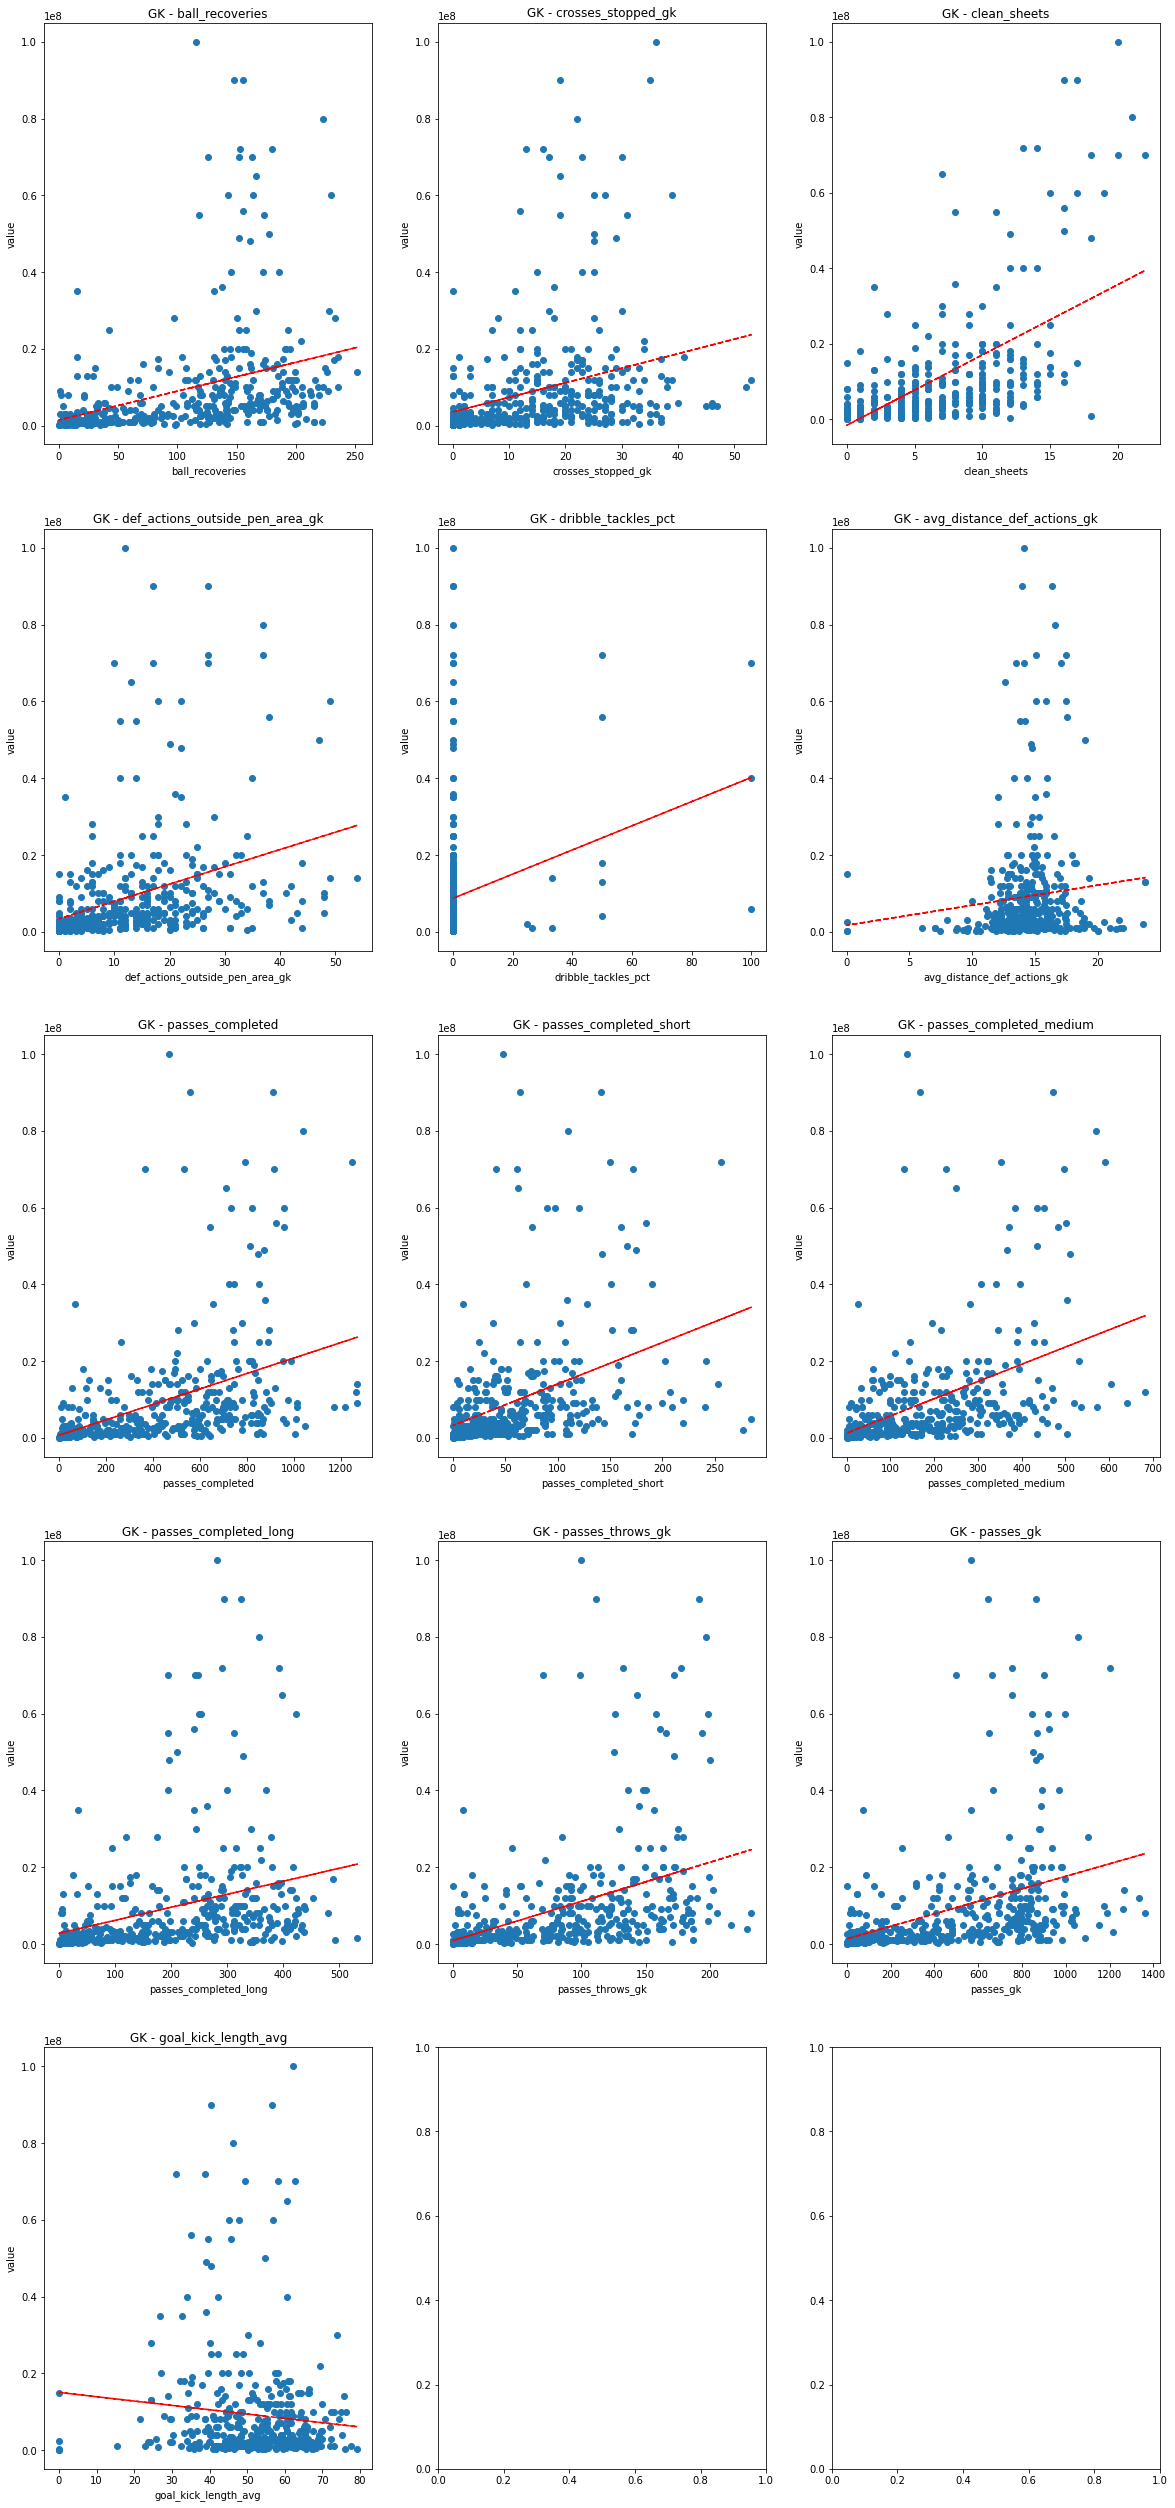

In [43]:

# fig, axs = plt.subplots(4, 5, figsize=(18,15), sharey='all', sharex='col')
plt.subplots(5, 3,figsize=(20,45))
df_i = 1
for feature in gk_feat:
    
    y = df2_GK['value']
    axs = plt.subplot(5,3,df_i)
    x = df2_GK[feature]
    # idx = (17, df_i)
    axs.scatter(x, y)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    axs.plot(x, p(x), "r--")
    axs.set_title('GK - ' + feature)
    axs.set_xlabel(feature)
    axs.set_ylabel('value')
    df_i += 1
    


In [44]:
df_for_position = [df2[df2['main_position']==pos] for pos in df2['main_position'].unique()]
len(df_for_position)

4

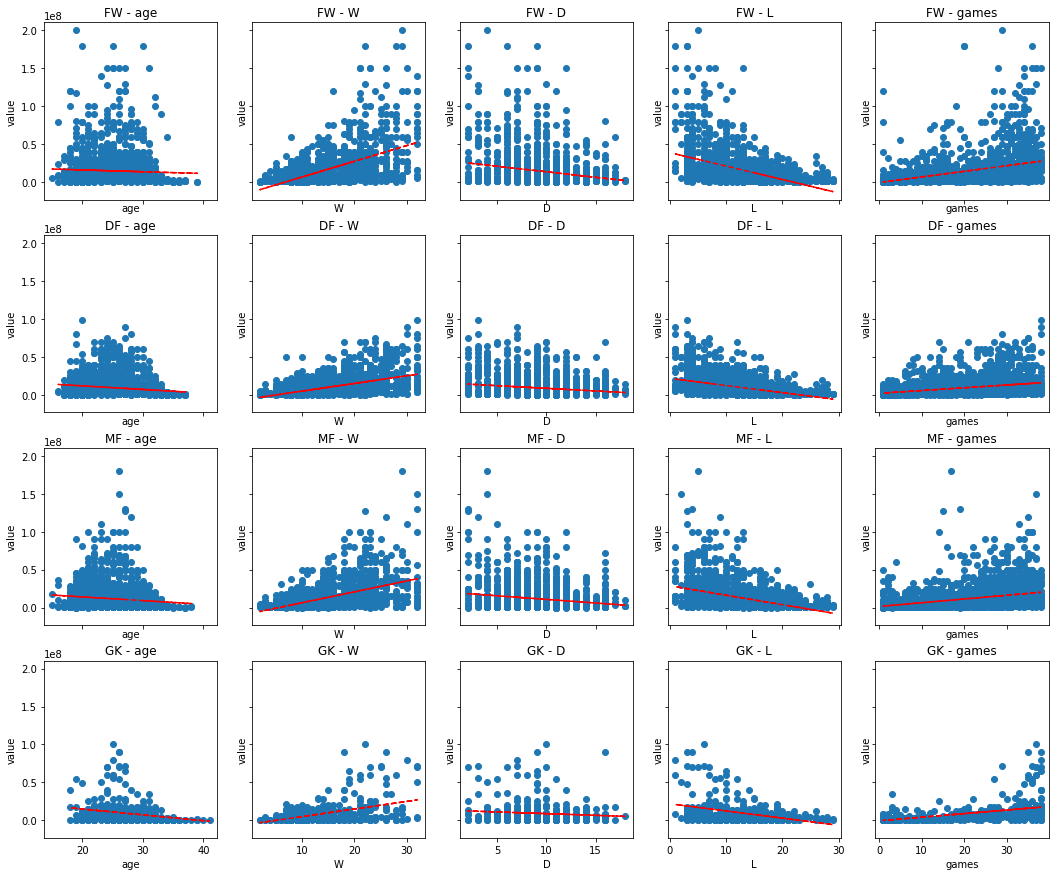

In [45]:
features = ['age', 'W', 'D', 'L','games']


# Create four polar axes and access them through the returned array
fig, axs = plt.subplots(4, 5, figsize=(18,15), sharey='all', sharex='col')

features_i = 0
for feature in features:
    df_i = 0
    for df_pos in df_for_position:
        idx = (df_i, features_i)
        x = df_pos[feature]
        y = df_pos['value']
        axs[idx].scatter(x, y)
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        axs[idx].plot(x, p(x), "r--")
        
        
        axs[idx].set_title(df_pos['position'].min() + ' - ' + feature)
        axs[idx].set_ylabel('value')
        axs[idx].set_xlabel(feature)
        df_i += 1
    features_i += 1

In [46]:
df2.shape

(6198, 400)

In [47]:
# a = ['passes','passes_left_foot', 'passes_right_foot','passes_head']
# df2[a]
df2.head(2)

,player,nationality,position,squad,age,birth_year,value,height,position2,foot,...,xG,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season,main_position
0,Aaron Connolly,ie IRL,FW,Brighton,19.0,2000.0,4000000,175.0,Forward - Centre-Forward,right,...,41.2,54.5,-13.3,-0.35,22369,0.0,0.0,0.0,201920,FW
1,Aaron Cresswell,eng ENG,DF,West Ham,27.0,1989.0,12000000,170.0,Defender - Left-Back,left,...,37.3,57.8,-20.5,-0.54,56885,0.0,0.0,0.0,201718,DF


In [48]:
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


FuncF = FuncFormatter(millions)

In [49]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
def show_values_on_bars_formatted(axs, h_v="v", space=0.4): 
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, FuncF(value), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, FuncF(value), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

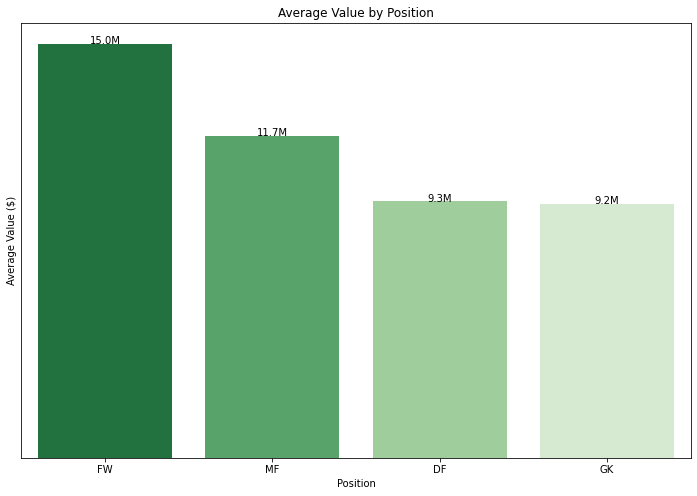

In [50]:
plt.figure(figsize=(12,8))
by_position = df2[["value", 'main_position']].groupby('main_position').mean().sort_values(by='value', ascending=False)
    
g = sns.barplot(x=by_position.index, y=by_position.value,
                palette="Greens_r")

g.set_title("Average Value by Position")
g.set_ylabel('Average Value ($)')
g.set_xlabel('Position')

g.set(yticks=[]) 
show_values_on_bars_formatted(g, h_v="v")

plt.show()

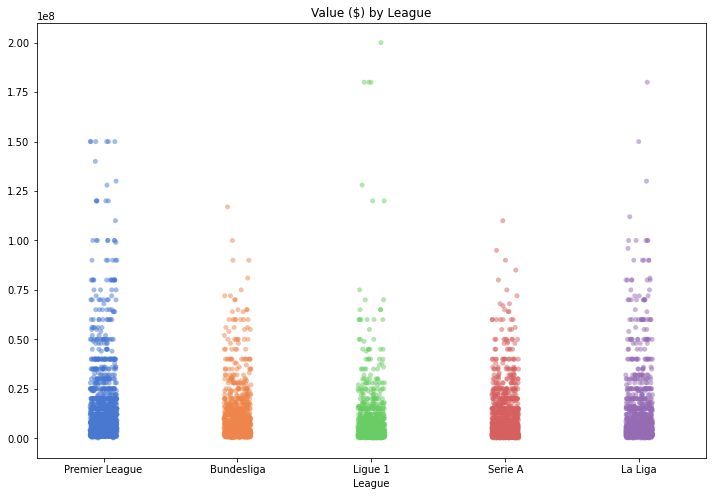

In [51]:
plt.figure(figsize=(12,8))

g = sns.stripplot(x="league", y="value", data=df2, palette="muted",
                 alpha=0.5, jitter=True,)



g.set_title("Value ($) by League")
g.set_ylabel('Value ($)')
g.set_xlabel('')

g.set_xlabel('League')
g.set_ylabel('')


plt.show()

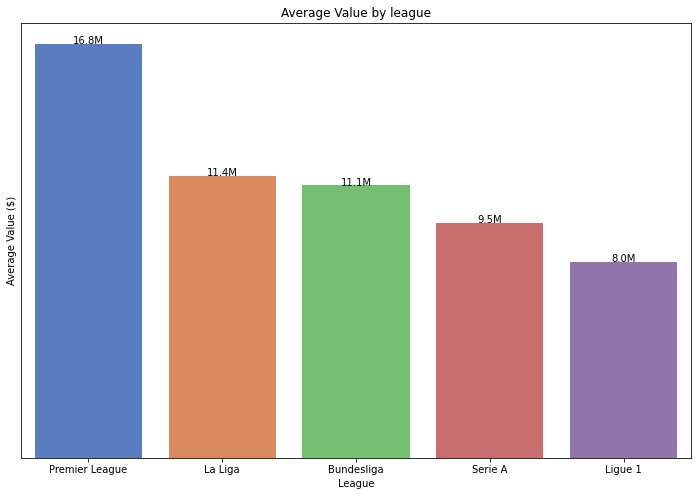

In [52]:
plt.figure(figsize=(12,8))
by_league = df2[["value", 'league']].groupby('league').mean().sort_values(by='value', ascending=False)
    
g = sns.barplot(x=by_league.index, y=by_league.value,
                palette="muted")

g.set_title("Average Value by league")
g.set_ylabel('Average Value ($)')
g.set_xlabel('League')

g.set(yticks=[]) 
show_values_on_bars_formatted(g, h_v="v")

plt.show()

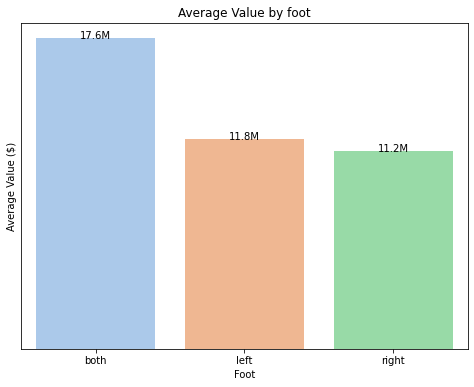

In [53]:
plt.figure(figsize=(8,6))
by_foot = df2[["value", 'foot']].groupby('foot').mean().sort_values(by='value', ascending=False)
    
g = sns.barplot(x=by_foot.index, y=by_foot.value,
                palette="pastel")

g.set_title("Average Value by foot")
g.set_ylabel('Average Value ($)')
g.set_xlabel('Foot')

g.set(yticks=[]) 
show_values_on_bars_formatted(g, h_v="v")

plt.show()

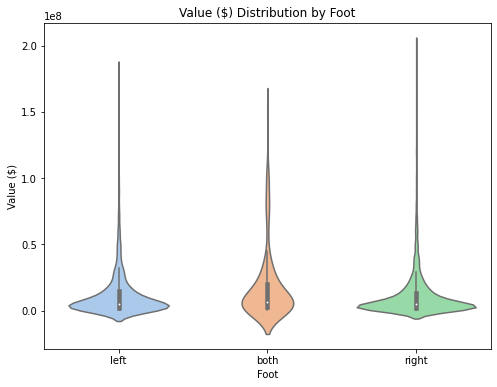

In [54]:
by_foot = df2[["value", "foot"]].groupby("foot").mean()

plt.figure(figsize=(8,6))

g = sns.violinplot(x=df2.foot, y=df2.value, palette="pastel", order=["left", "both", "right"])

g.set_title("Value ($) Distribution by Foot")
g.set_ylabel('Value ($)')
g.set_xlabel('Foot')


plt.show()

In [55]:
df2.foot.value_counts()

right    4436
left     1569
both      188
Name: foot, dtype: int64

<Figure size 1296x792 with 0 Axes>

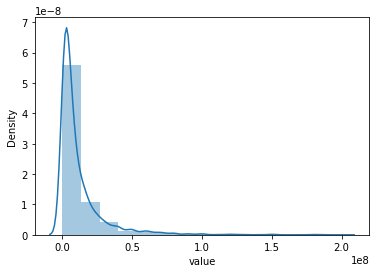

In [56]:
plt.figure(figsize=(18,11))
ax = plt.subplots()
ax = sns.distplot(df2['value'],kde=True,hist=True,bins=15)
plt.show()
# plt.hist(df2.value, bins=15)
# df2.value

타겟(value)가 right-skewed 된 상태

로그 변환을 시도해 대칭에 가깝게 변화 시도




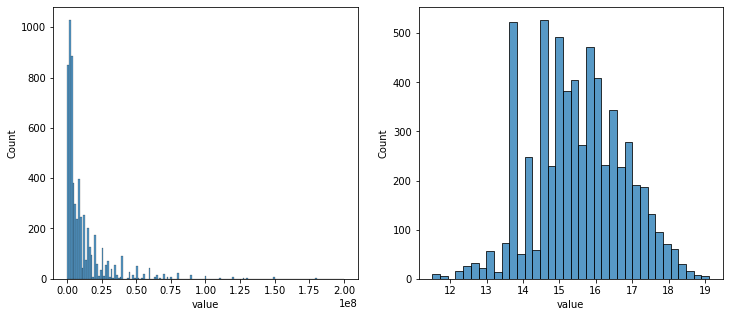

In [57]:
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df2['value'], ax=ax[0])
sns.histplot(np.log1p(df2['value']), ax=ax[1])

n233 TransformedTargetRegressor 방법 참고해서 모델 만들기

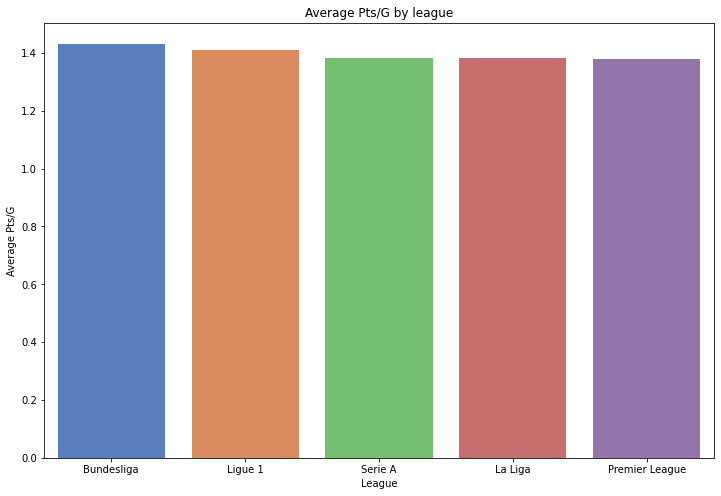

In [58]:
plt.figure(figsize=(12,8))
by_league = df2[["Pts/G", 'league']].groupby('league').mean().sort_values(by='Pts/G', ascending=False)
    
g = sns.barplot(x=by_league.index, y=by_league['Pts/G'],
                palette="muted")

g.set_title("Average Pts/G by league")
g.set_ylabel('Average Pts/G')
g.set_xlabel('League')



plt.show()

### 시즌스텟 변화에 따른 가치변동

In [59]:
df3[df3['player'] == 'Óscar Melendo']

,player,main_position,value,aerials_won_pct,assists_per90,passes_blocked,carry_distance,ball_recoveries,crosses,crosses_into_penalty_area,...,d_shots_total_per90,d_goals_per90,d_goals_per_shot,d_games,d_tackles,d_pressures,d_W,d_D,d_L,d_Pts/G
6187,Óscar Melendo,MF,1000000,25.0,0.13,9.0,1480.0,57.0,5.0,2.0,...,,,,,,,,,,
6188,Óscar Melendo,MF,10000000,28.9,0.23,20.0,5304.0,147.0,16.0,3.0,...,-0.5,0.0,0.0,14.0,18.0,272.0,2.0,-2.0,0.0,0.1


In [60]:
# df3 = df3.astype({'diff_val' : 'float64'})


In [61]:
df_diff = df3[df3['diff_val']!='']

In [62]:
d_feat = ['diff_val','main_position','d_aerials_won_pct', 'd_assists_per90','d_passes_blocked','d_carry_distance','d_ball_recoveries','d_crosses',
          'd_crosses_into_penalty_area', 'd_dribbles', 'd_dribbles_completed_pct', 'd_gca_per90', 'd_GDiff', 'd_goals_assists_per90', 'd_minutes_90s',
          'd_npxg_xa_per90', 'd_passes_intercepted', 'd_passes_pct', 'd_passes_received_pct', 'd_sca_per90',
             'd_shots_on_target_pct', 'd_shots_total_per90', 'd_goals_per90', 'd_goals_per_shot','d_games',
          'd_tackles', 'd_pressures','d_W', 'd_D', 'd_L', 'd_Pts/G','league','foot']

In [63]:
df_diff = df_diff[d_feat]

In [64]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2798 entries, 2 to 6195
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   diff_val                     2798 non-null   object
 1   main_position                2798 non-null   object
 2   d_aerials_won_pct            2798 non-null   object
 3   d_assists_per90              2798 non-null   object
 4   d_passes_blocked             2798 non-null   object
 5   d_carry_distance             2798 non-null   object
 6   d_ball_recoveries            2798 non-null   object
 7   d_crosses                    2798 non-null   object
 8   d_crosses_into_penalty_area  2798 non-null   object
 9   d_dribbles                   2798 non-null   object
 10  d_dribbles_completed_pct     2798 non-null   object
 11  d_gca_per90                  2798 non-null   object
 12  d_GDiff                      2798 non-null   object
 13  d_goals_assists_per90        2798

In [65]:
dr = df_diff.loc[:,'main_position']
dr2 = df_diff.loc[:,'league']
dr3 = df_diff.loc[:,'foot']

In [66]:
d_feat2 = ['diff_val','d_aerials_won_pct', 'd_assists_per90','d_passes_blocked','d_carry_distance','d_ball_recoveries','d_crosses',
          'd_crosses_into_penalty_area', 'd_dribbles', 'd_dribbles_completed_pct', 'd_gca_per90', 'd_GDiff', 'd_goals_assists_per90', 'd_minutes_90s',
          'd_npxg_xa_per90', 'd_passes_intercepted', 'd_passes_pct', 'd_passes_received_pct', 'd_sca_per90',
             'd_shots_on_target_pct', 'd_shots_total_per90', 'd_goals_per90', 'd_goals_per_shot','d_games',
           'd_tackles', 'd_pressures','d_W', 'd_D', 'd_L', 'd_Pts/G']
df_diff = df_diff[d_feat2].astype(dtype = 'float64')

In [67]:
df_diff = pd.concat([df_diff,dr],axis=1)
df_diff = pd.concat([df_diff,dr2],axis=1)
df_diff = pd.concat([df_diff,dr3],axis=1)

In [68]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2798 entries, 2 to 6195
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   diff_val                     2798 non-null   float64
 1   d_aerials_won_pct            2798 non-null   float64
 2   d_assists_per90              2798 non-null   float64
 3   d_passes_blocked             2798 non-null   float64
 4   d_carry_distance             2798 non-null   float64
 5   d_ball_recoveries            2798 non-null   float64
 6   d_crosses                    2798 non-null   float64
 7   d_crosses_into_penalty_area  2798 non-null   float64
 8   d_dribbles                   2798 non-null   float64
 9   d_dribbles_completed_pct     2798 non-null   float64
 10  d_gca_per90                  2798 non-null   float64
 11  d_GDiff                      2798 non-null   float64
 12  d_goals_assists_per90        2798 non-null   float64
 13  d_minutes_90s     

In [69]:
df_diff

,diff_val,d_aerials_won_pct,d_assists_per90,d_passes_blocked,d_carry_distance,d_ball_recoveries,d_crosses,d_crosses_into_penalty_area,d_dribbles,d_dribbles_completed_pct,...,d_games,d_tackles,d_pressures,d_W,d_D,d_L,d_Pts/G,main_position,league,foot
2,-2000000.0,2.4,-0.03,-8.0,-2453.0,-151.0,-63.0,-6.0,-3.0,24.0,...,-16.0,-12.0,-125.0,5.0,-5.0,0.0,0.26,DF,Premier League,left
3,-4000000.0,2.4,-0.06,37.0,1269.0,128.0,24.0,9.0,25.0,-19.4,...,11.0,24.0,122.0,-5.0,2.0,3.0,-0.34,DF,Premier League,left
6,0.0,-20.0,-0.16,-6.0,-660.0,-6.0,-11.0,-1.0,-7.0,-27.2,...,1.0,-5.0,-71.0,-1.0,-2.0,3.0,-0.13,FW,Premier League,right
7,0.0,-20.0,0.07,1.0,512.0,14.0,13.0,1.0,-2.0,18.0,...,1.0,18.0,93.0,-2.0,-3.0,5.0,-0.24,FW,Premier League,right
8,-3000000.0,27.3,-0.07,-9.0,-1019.0,-40.0,-9.0,-1.0,-7.0,21.7,...,0.0,-18.0,-91.0,4.0,2.0,-6.0,0.37,MF,Premier League,right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6184,3000000.0,-4.0,0.06,-3.0,-2432.0,54.0,-1.0,1.0,11.0,-8.3,...,1.0,9.0,104.0,0.0,1.0,-1.0,0.02,MF,La Liga,right
6186,0.0,7.6,0.00,-3.0,-356.0,-56.0,0.0,0.0,-2.0,-100.0,...,0.0,3.0,7.0,2.0,-2.0,0.0,0.10,DF,La Liga,right
6188,9000000.0,3.9,0.10,11.0,3824.0,90.0,11.0,1.0,36.0,19.3,...,14.0,18.0,272.0,2.0,-2.0,0.0,0.10,MF,La Liga,left
6193,0.0,1.6,-0.09,20.0,1373.0,59.0,19.0,3.0,10.0,-25.3,...,9.0,32.0,85.0,3.0,1.0,-4.0,0.26,DF,La Liga,right


In [70]:
# df_diff.nationality.value_counts()

In [71]:
df_diff.isna().sum()[df_diff.isna().sum()!=0]/len(df_diff) # 결측치 비율

foot    0.000357
dtype: float64

In [72]:
df_diff.nunique()[df_diff.nunique()/len(df_diff)>0.7] # 카디널리티

d_carry_distance    2302
dtype: int64

In [73]:
# features = ['assisted_shots','assists']
# df_diff[features]

In [74]:
# df_diff['value'].dtype

In [75]:
num_features = df3.dtypes[df3.dtypes!='object'].index
df3[num_features].corr()['value'].sort_values(ascending=False).head(10)

value                  1.000000
W                      0.500130
GDiff                  0.491532
Pts/G                  0.487625
carry_distance         0.448864
dribbles               0.401729
passes_intercepted     0.375222
goals_assists_per90    0.351112
minutes_90s            0.328488
games                  0.325917
Name: value, dtype: float64

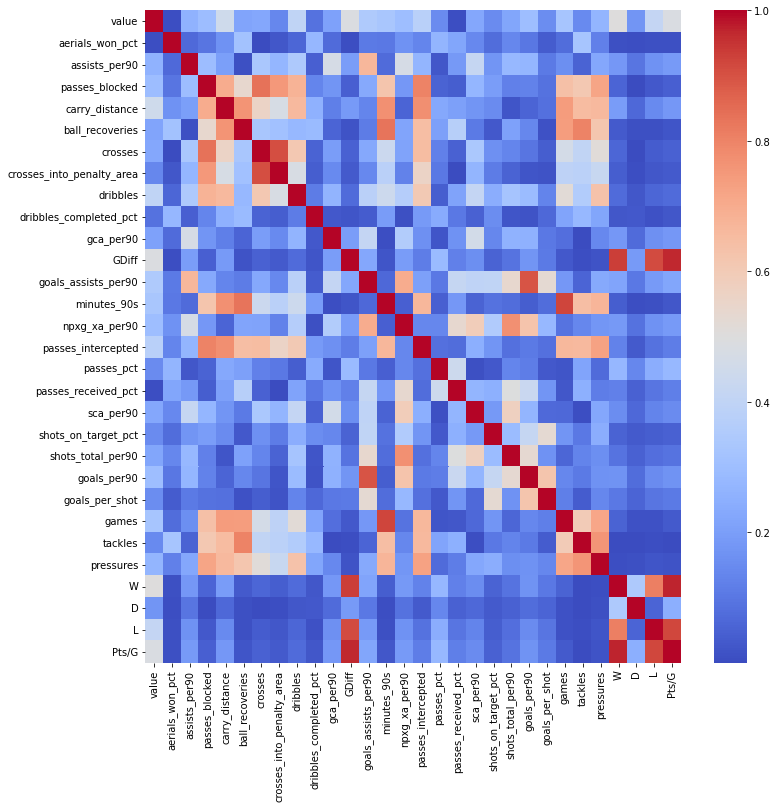

In [76]:
v_corr = df3.corr()
plt.figure(figsize=(12,12))
sns.heatmap(abs(v_corr), cmap="coolwarm")

가치 변화와 지표들과의 corr확인

In [77]:
d_corr = df_diff.corr()

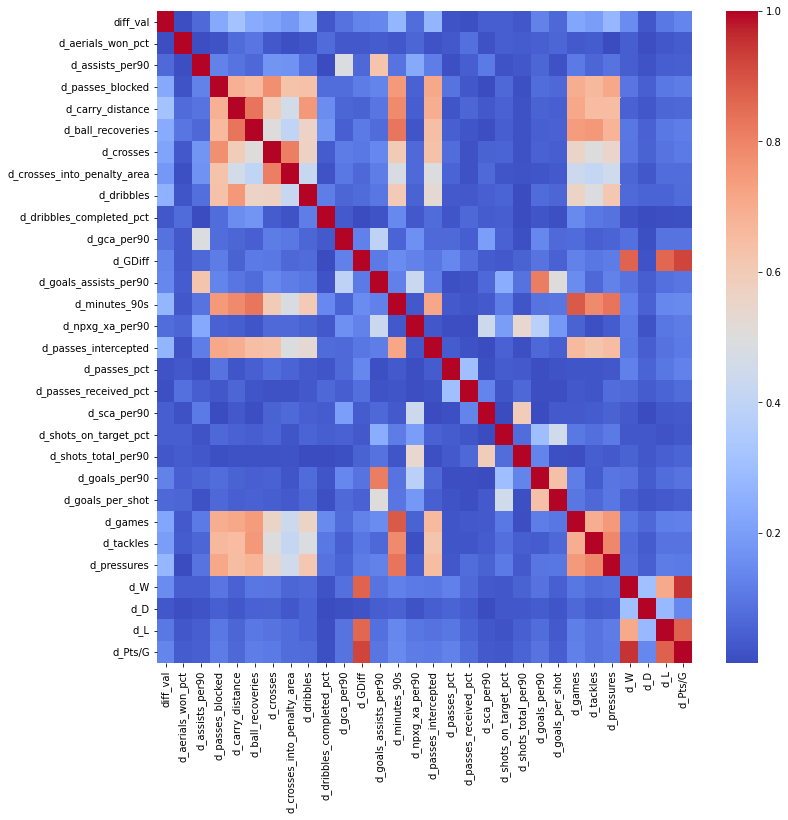

In [78]:
plt.figure(figsize=(12,12))
sns.heatmap(abs(d_corr), cmap="coolwarm")

In [79]:
df_diff.corr()['diff_val'].sort_values(ascending=False).head(10)

diff_val                1.000000
d_carry_distance        0.312825
d_pressures             0.275307
d_minutes_90s           0.270099
d_passes_intercepted    0.269454
d_dribbles              0.261041
d_ball_recoveries       0.236340
d_passes_blocked        0.233568
d_games                 0.222452
d_crosses               0.218035
Name: diff_val, dtype: float64

In [80]:
df_diff_ngk = df_diff[df_diff.main_position == 'FW']

In [81]:
df_diff_ngk.corr()['diff_val'].sort_values(ascending=False).head(10)

diff_val                1.000000
d_carry_distance        0.339052
d_dribbles              0.328205
d_pressures             0.314702
d_passes_intercepted    0.311567
d_minutes_90s           0.285024
d_passes_blocked        0.256882
d_ball_recoveries       0.247673
d_crosses               0.235072
d_games                 0.218162
Name: diff_val, dtype: float64

In [82]:
# df_diff[df_diff.main_position != 'GK']

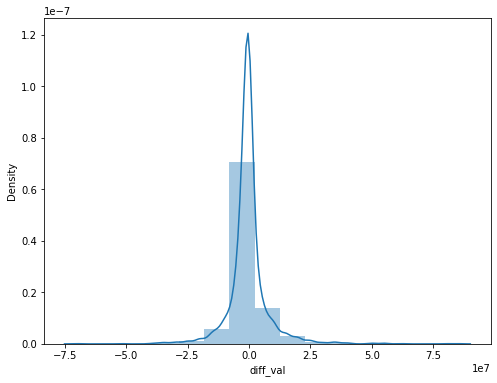

In [83]:
ax = plt.figure(figsize=(8,6))

ax = sns.distplot(df_diff['diff_val'],kde=True,hist=True,bins=15)

### 회귀분석 시작

In [84]:
# import 모음
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor

In [85]:
target = 'diff_val'
features = df_diff.drop(columns=[target]).columns
train, test = train_test_split(df_diff, test_size=0.2, random_state=2)

# feature과 label을 분리합니다.
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

In [86]:
print(X_train.shape)
print(X_test.shape)

(2238, 32)
(560, 32)


In [87]:
baseline = [y_train.mean()] * len(y_train)
baseline_r2 = r2_score(y_train, baseline)
baseline_mae = mean_absolute_error(y_train, baseline)
print(f'기준모델의 r2_score: {baseline_r2}')
print(f'기준모델의 mae : {baseline_mae}')

기준모델의 r2_score: 0.0
기준모델의 mae : 4523914.536549214


In [88]:
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

numeric_feats = X_train.dtypes[X_train.dtypes != "object"].index

scaler = StandardScaler()
X_train[numeric_feats] = scaler.fit_transform(X_train[numeric_feats])
X_test[numeric_feats] = scaler.transform(X_test[numeric_feats])

In [89]:
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)

In [90]:
selector = SelectKBest(score_func= f_regression, k=20)

X_train_selected = selector.fit_transform(X_train_ohe, y_train)

X_test_selected = selector.transform(X_test_ohe)

selector.get_feature_names_out()

array(['d_assists_per90', 'd_passes_blocked', 'd_carry_distance',
       'd_ball_recoveries', 'd_crosses', 'd_crosses_into_penalty_area',
       'd_dribbles', 'd_gca_per90', 'd_GDiff', 'd_goals_assists_per90',
       'd_minutes_90s', 'd_npxg_xa_per90', 'd_passes_intercepted',
       'd_goals_per90', 'd_games', 'd_tackles', 'd_pressures', 'd_W',
       'd_L', 'd_Pts/G'], dtype=object)

In [91]:
ols_fs = LinearRegression()
ols_fs.fit(X_train_selected, y_train)



# 성능 비교
# ols_fs_train, ols_fs_val, ols_fs_test = print_score2(ols_fs, X_train_selected, y_train, X_test_selected, y_test)
print('학습 R2 score: {0:.3f}'.format(ols_fs.score(X_train_selected, y_train)))
print('테스트 R2 score: {0:.3f}'.format(ols_fs.score(X_test_selected, y_test)))

학습 R2 score: 0.180
테스트 R2 score: 0.068


오늘 끝낼 내용

시각화 마무리 짓고 , 모델은 내일 

value와 diff_val 분포 시각화, 리그, 주발로 나눌수 있으려나?

r2 처참하게 나옴, feature를 고르지말고 전체로하고 카디널 높은 nation, squad,player만 제거하고 다시 돌려봐야할듯

In [92]:
df2.shape

(6198, 400)

In [93]:
df2.corr()['Pts/G'].sort_values(ascending=False).head(10)

Pts/G        1.000000
Pts          0.970844
W            0.969046
GDiff        0.967254
xGDiff       0.892930
xGDiff/90    0.892446
GF           0.862215
xG           0.791708
CL           0.753485
value        0.487625
Name: Pts/G, dtype: float64

### test2

value를 기준으로한 모델

In [94]:
df2.columns.values
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6198 entries, 0 to 6197
Columns: 400 entries, player to main_position
dtypes: float64(389), int64(2), object(9)
memory usage: 18.9+ MB


In [95]:
df2.dtypes[df2.dtypes=='object'].index

Index(['player', 'nationality', 'position', 'squad', 'position2', 'foot',
       'league', 'Attendance', 'main_position'],
      dtype='object')

In [96]:
obj = ['player', 'nationality', 'position', 'squad', 'position2', 'Attendance'] # foot, league, main_position만 남김
drop_feat = ['W','Pts','D','L','LgRk','xGDiff','GDiff','xGDiff/90','GF','xG' ]

In [97]:
df_a = df2.drop(obj, axis=1)
df_a = df_a.drop(drop_feat, axis=1)
df_a_FW = df_a[df_a.main_position == 'FW']
df_a_MF = df_a[df_a.main_position == 'MF']
df_a_DF = df_a[df_a.main_position == 'DF']
df_a_GK = df_a[df_a.main_position == 'GK']
df_a_GK

,age,birth_year,value,height,foot,league,games,games_starts,minutes,goals,...,avg_distance_def_actions_gkm,MP,GA,Pts/G,xGA,CL,WinCL,CLBestScorer,Season,main_position
15,21.0,1998.0,12000000,191.0,right,Premier League,37.0,37.0,3330.0,0.0,...,0.004264,38.0,65.0,0.89,57.5,0.0,0.0,0.0,201920,GK
35,25.0,1992.0,1000000,191.0,right,Ligue 1,3.0,3.0,270.0,0.0,...,0.000000,38.0,44.0,1.53,53.5,0.0,0.0,0.0,201718,GK
36,26.0,1992.0,1000000,191.0,right,Ligue 1,6.0,6.0,495.0,0.0,...,0.027677,38.0,52.0,1.37,48.7,0.0,0.0,0.0,201819,GK
116,30.0,1987.0,5000000,190.0,right,Premier League,19.0,19.0,1710.0,0.0,...,0.000000,38.0,68.0,1.11,57.8,0.0,0.0,0.0,201718,GK
122,32.0,1987.0,4000000,190.0,right,Premier League,11.0,9.0,875.0,0.0,...,0.014857,38.0,33.0,2.61,40.0,1.0,1.0,0.0,201920,GK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6132,23.0,1994.0,3000000,190.0,right,Bundesliga,1.0,1.0,90.0,0.0,...,0.000000,34.0,53.0,1.56,45.7,0.0,0.0,0.0,201718,GK
6133,24.0,1994.0,3000000,186.0,right,Bundesliga,2.0,1.0,135.0,0.0,...,0.071111,34.0,29.0,1.94,35.0,1.0,0.0,0.0,201819,GK
6134,25.0,1994.0,2000000,186.0,right,Bundesliga,2.0,2.0,180.0,0.0,...,0.089444,34.0,37.0,1.94,36.4,1.0,0.0,0.0,201920,GK
6136,26.0,1992.0,900000,180.0,right,Ligue 1,2.0,2.0,180.0,0.0,...,0.087778,38.0,49.0,1.21,46.9,0.0,0.0,0.0,201819,GK


In [98]:
df_a.corr()['Pts/G'].sort_values(ascending=False).head(10)

Pts/G               1.000000
CL                  0.753485
value               0.487625
passes_receivedm    0.282719
passes_pct          0.280439
gca_passes_live     0.279103
passes_groundm      0.277294
passes_ground       0.260863
passes_livem        0.256535
carriesm            0.249939
Name: Pts/G, dtype: float64

In [99]:
target = 'value'
features = df_a.drop(columns=[target]).columns
train, test = train_test_split(df_a, test_size=0.2, random_state=42)


# feature과 label을 분리합니다.
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=2)

In [100]:
baseline = [y_train.mean()] * len(y_train)
baseline_r2 = r2_score(y_train, baseline)
print(f'기준모델의 r2_score: {baseline_r2}')

기준모델의 r2_score: 0.0


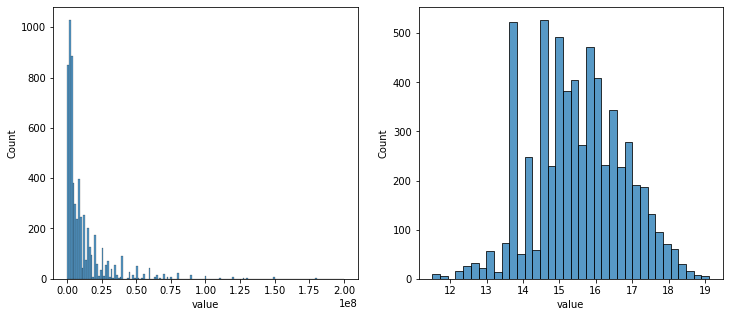

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_a[target], ax=ax[0])
sns.histplot(np.log1p(df_a[target]), ax=ax[1])

In [102]:
df_a['value'] = np.log1p(df_a['value'])

In [103]:
X_train.fillna(X_train.mean(), inplace=True)
X_val.fillna(X_val.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

numeric_feats = X_train.dtypes[X_train.dtypes != "object"].index

scaler = StandardScaler()
X_train[numeric_feats] = scaler.fit_transform(X_train[numeric_feats])
X_val[numeric_feats] = scaler.transform(X_val[numeric_feats])
X_test[numeric_feats] = scaler.transform(X_test[numeric_feats])

In [104]:
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train)
X_val_ohe = ohe.transform(X_val)
X_test_ohe = ohe.transform(X_test)

In [105]:
selector = SelectKBest(score_func= f_regression, k=6)

X_train_selected = selector.fit_transform(X_train_ohe, y_train)
X_val_selected = selector.transform(X_val_ohe)
X_test_selected = selector.transform(X_test_ohe)

selector.get_feature_names_out()

array(['goals', 'npxg', 'shots_on_target', 'gca', 'gca_passes_live',
       'pass_targets'], dtype=object)

In [106]:
ols_fs = LinearRegression()
ols_fs.fit(X_train_selected, y_train)

print('학습 R2 score: {0:.3f}'.format(ols_fs.score(X_train_selected, y_train)))
print('검증 R2 score: {0:.3f}'.format(ols_fs.score(X_val_selected, y_val)))
print('테스트 R2 score: {0:.3f}'.format(ols_fs.score(X_test_selected, y_test)))

학습 R2 score: 0.355
검증 R2 score: 0.382
테스트 R2 score: 0.339


In [107]:
params = {
    'n_estimators':(100, 200),
    'max_depth' : (5, 8),
    'min_samples_leaf' : (8, 18),
    'min_samples_split' : (8, 16)
}
rf_run = RandomForestRegressor(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_run, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train_selected, y_train)
 
 
print('최적 하이퍼 파라미터:', grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 200}
최적 예측 정확도: 0.3772


In [108]:
rf_run = RandomForestRegressor(random_state=0, max_depth=5, min_samples_leaf=8, min_samples_split=8,n_estimators=200)
rf_run.fit(X_train_selected, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=8, min_samples_split=8,
                      n_estimators=200, random_state=0)

In [109]:
print('테스트 R2 score: {0:.3f}'.format(rf_run.score(X_test_selected, y_test)))

테스트 R2 score: 0.394


In [110]:
datas = pd.DataFrame(X_val_selected,columns = selector.get_feature_names_out())

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8de11e2850>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8de11db650>})

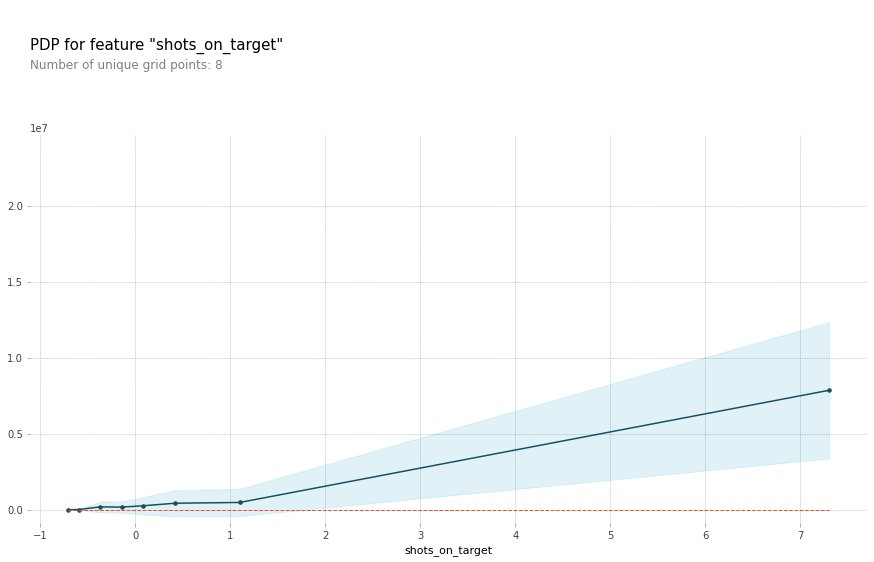

In [111]:
from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature = "shots_on_target"

isolated = pdp_isolate(
    model=rf_run,
    dataset=datas,
    model_features=datas.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8dded62490>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8dded5f590>})

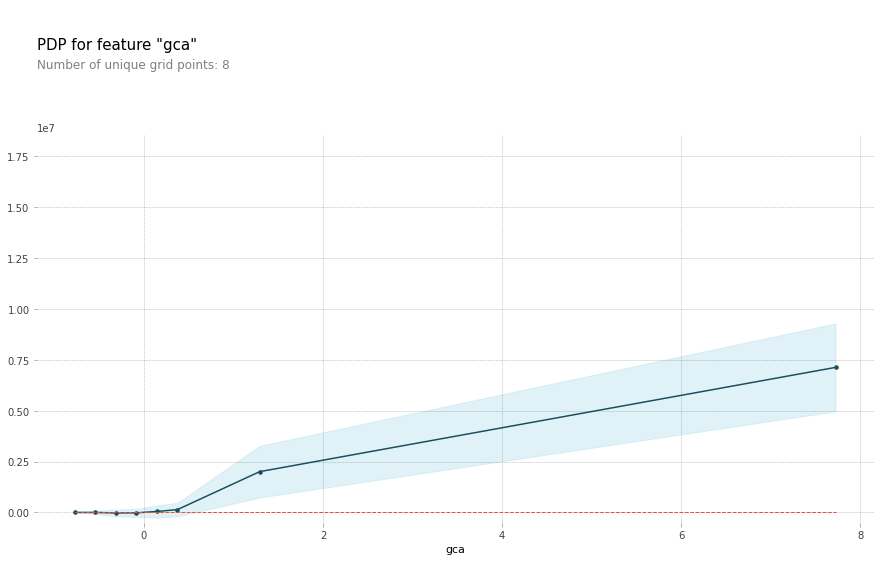

In [112]:
from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature = "gca"

isolated = pdp_isolate(
    model=rf_run,
    dataset=datas,
    model_features=datas.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

Pts/G를 타겟으로 한 모델

Text(0.5, 0, 'Pts/G')

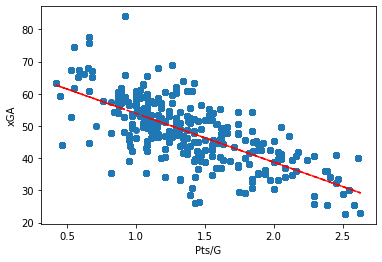

In [113]:
y = df_a['xGA']
x = df_a['Pts/G']
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

plt.ylabel('xGA')
plt.xlabel('Pts/G')


In [114]:
# y = df_a['xGDiff/90']
# x = df_a['Pts/G']
# plt.scatter(x, y)
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# plt.plot(x, p(x), "r--")

# plt.ylabel('xGDiff/90')
# plt.xlabel('Pts/G')

In [115]:
target = 'Pts/G'
features = df_a.drop(columns=[target]).columns
train, test = train_test_split(df_a, test_size=0.2, random_state=42)


# feature과 label을 분리합니다.
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=2)

baseline = [y_train.mean()] * len(y_train)
baseline_r2 = r2_score(y_train, baseline)
print(f'기준모델의 r2_score: {baseline_r2}')

기준모델의 r2_score: 0.0


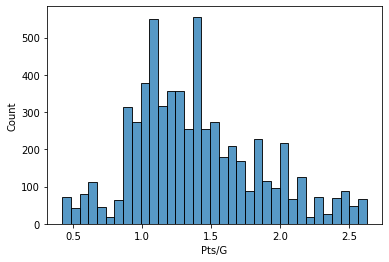

In [116]:
sns.histplot(df_a[target])

In [117]:
X_train.fillna(X_train.mean(), inplace=True)
X_val.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

numeric_feats = X_train.dtypes[X_train.dtypes != "object"].index

scaler = StandardScaler()
X_train[numeric_feats] = scaler.fit_transform(X_train[numeric_feats])
X_val[numeric_feats] = scaler.transform(X_val[numeric_feats])
X_test[numeric_feats] = scaler.transform(X_test[numeric_feats])

In [118]:
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train)
X_val_ohe = ohe.transform(X_val)
X_test_ohe = ohe.transform(X_test)

selector = SelectKBest(score_func= f_regression, k=8)

X_train_selected = selector.fit_transform(X_train_ohe, y_train)
X_val_selected = selector.transform(X_val_ohe)
X_test_selected = selector.transform(X_test_ohe)

selector.get_feature_names_out()

array(['value', 'passes_pct', 'gca_passes_live', 'passes_groundm',
       'passes_receivedm', 'GA', 'xGA', 'CL'], dtype=object)

In [119]:
ols_fs = LinearRegression()
ols_fs.fit(X_train_selected, y_train)

print('학습 R2 score: {0:.3f}'.format(ols_fs.score(X_train_selected, y_train)))
print('검증 R2 score: {0:.3f}'.format(ols_fs.score(X_val_selected, y_val)))
print('테스트 R2 score: {0:.3f}'.format(ols_fs.score(X_test_selected, y_test)))

학습 R2 score: 0.791
검증 R2 score: 0.767
테스트 R2 score: 0.752


In [120]:
params = {
    'n_estimators':(100, 200),
    'max_depth' : (5, 8),
    'min_samples_leaf' : (8, 18),
    'min_samples_split' : (8, 16)
}
rf_run = RandomForestRegressor(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_run, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train_selected, y_train)
 
 
print('최적 하이퍼 파라미터:', grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최적 예측 정확도: 0.8702


In [121]:
rf_run = RandomForestRegressor(random_state=0, max_depth=8, min_samples_leaf=8, min_samples_split=8,n_estimators=100)
rf_run.fit(X_train_selected, y_train)

RandomForestRegressor(max_depth=8, min_samples_leaf=8, min_samples_split=8,
                      random_state=0)

In [122]:
print('테스트 R2 score: {0:.3f}'.format(rf_run.score(X_test_selected, y_test)))

테스트 R2 score: 0.879


In [123]:
datas = pd.DataFrame(X_val_selected,columns = selector.get_feature_names_out())

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8dde9f68d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8de10bfe90>})

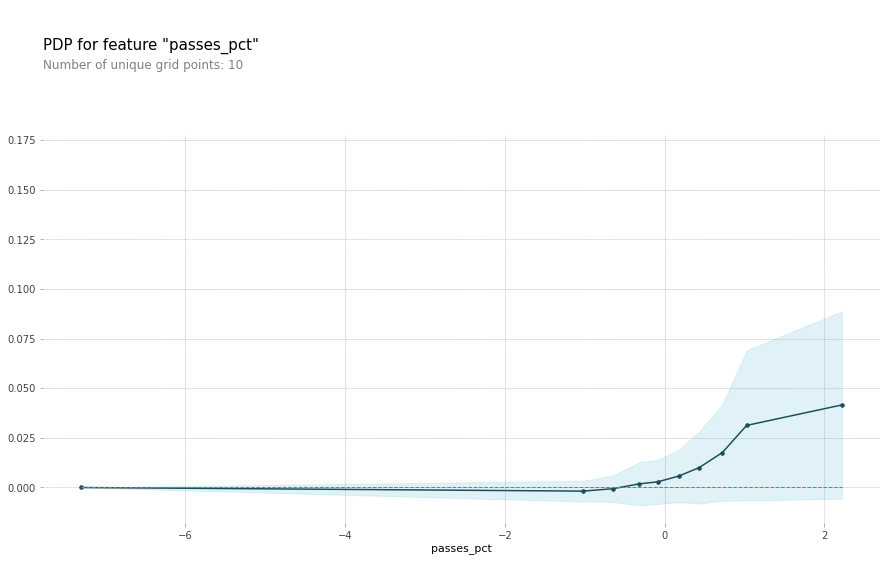

In [124]:
from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature = "passes_pct"

isolated = pdp_isolate(
    model=rf_run,
    dataset=datas,
    model_features=datas.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8ddea07c50>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8ddea6a2d0>})

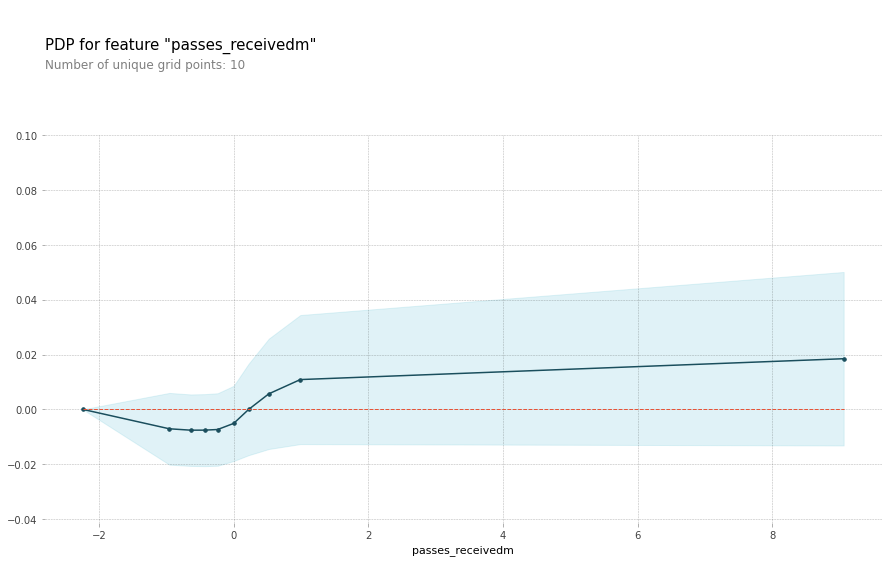

In [125]:
target_feature = "passes_receivedm"

isolated = pdp_isolate(
    model=rf_run,
    dataset=datas,
    model_features=datas.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)